In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad, quad_vec
from scipy.optimize import minimize
from scipy.stats import norm
from patsy import bs

In [2]:
%load_ext rpy2.ipython

C:\Users\Jater\AppData\Local\Programs\Python\Python38\lib\site-packages\rpy2\robjects\packages.py:366: UserWarning: The symbol 'quartz' is not in this R namespace/package.
  warnings.warn(


In [3]:
%%R
set.seed(1)
mu1 = .2
mu2 = .7
n <- 1000
m <- n*10
z <- rnorm(m, mean=mu1, sd=.1); x <- z[(z>0)&(z<1)]
x <- x[1:n]
z <- rnorm(m, mean=mu2, sd=.2); x2 <- z[(z>0)&(z<1)]
x2 <- x2[1:n]
z <- sample(0:1, size = n, replace=T)
x[z==1] <- x2[z==1]

In [4]:
mu1 = %R mu1
mu2 = %R mu2
n = %R n
m = %R m
x = %R x
x2 = %R x2
z = %R z
knotlist = [i/9 for i in range(1, 9)]
nb = len(knotlist) + 4

In [5]:
M = np.zeros((nb, nb))
for i in range(nb):
    for j in range(nb):
        def tem(u):
            bx = bs(x=u, knots=knotlist, include_intercept=True, lower_bound=0, upper_bound=1)
            return bx[:, i]*bx[:, j]
        M[i, j] = quad(tem, 0, 1)[0]
        if j > i:
            M[j, i] = M[i, j]

### MLE fhat

In [6]:
def ln_fa(a):
    bx = bs(x=x, knots=knotlist, include_intercept=True, lower_bound=0, upper_bound=1)
    def temp(w):
        bx = bs(x=w, knots=knotlist, include_intercept=True, lower_bound=0, upper_bound=1)
        return np.exp(bx @ a)
    return -1*(bx @ (a - np.log(quad_vec(temp, 0, 1)[0]))).sum()

In [7]:
a = minimize(ln_fa, np.zeros(12))

In [8]:
print(a)

      fun: -82.89880118926378
 hess_inv: array([[ 1.27983973e-01, -1.99080781e-01,  9.90405212e-02,
        -1.22711365e-01,  5.98795570e-02, -1.65832291e-01,
         5.82831191e-02, -8.21794054e-03, -7.75905025e-02,
         3.19480554e-02, -4.23788939e-02, -2.30307286e-01],
       [-1.99080781e-01,  6.15282890e-01, -2.47354894e-01,
         4.49133872e-01, -2.40220856e-01,  7.10462600e-01,
        -2.06649322e-01,  4.98666147e-04,  3.65888943e-01,
        -1.72381403e-01,  2.99097902e-01,  6.70461482e-01],
       [ 9.90405212e-02, -2.47354894e-01,  1.22279144e-01,
        -1.84420214e-01,  9.48419579e-02, -2.68361200e-01,
         7.42749290e-02, -1.97650946e-03, -1.34682459e-01,
         5.79159366e-02, -1.20951605e-01, -2.61851939e-01],
       [-1.22711365e-01,  4.49133872e-01, -1.84420214e-01,
         3.88707498e-01, -2.08705396e-01,  5.97243145e-01,
        -1.66127065e-01,  9.17428171e-03,  3.00690887e-01,
        -1.27525253e-01,  2.49434212e-01,  5.30559339e-01],
       [ 5.

### True density f

In [9]:
k0 = norm.cdf(1, loc=mu1, scale=0.1) - norm.cdf(0, loc=mu1, scale=0.1)
k1 = norm.cdf(1, loc=mu2, scale=0.2) - norm.cdf(0, loc=mu2, scale=0.2)
def f(u):
    ans = 0.5*norm.pdf(u, loc=mu1, scale=.1)/k0 + 0.5*norm.pdf(u, loc=mu2, scale=.2)/k1
    ans[u>1] = 0
    ans[u<0] = 0
    return ans

In [22]:
def inside(w):
    bx = bs(x=w, knots=knotlist, include_intercept=True, lower_bound=0, upper_bound=1)
    return np.exp(bx @ a.x)

def fa(u):
    return inside(u) / quad(inside, 0, 1)[0]

In [18]:
def fa2(u):
    bx = bs(x=u, knots=knotlist, include_intercept=True, lower_bound=0, upper_bound=1)
    def temp(w):
        bx = bs(x=w, knots=knotlist, include_intercept=True, lower_bound=0, upper_bound=1)
        return np.exp(bx @ a.x)
    return np.exp(bx @ (a.x - np.log(quad_vec(temp, 0, 1)[0])))

In [12]:
def ise(u):
    return (fa(u) - f(u))**2

In [ ]:
# quad_vec(ise, 0, 1)[0]

[]

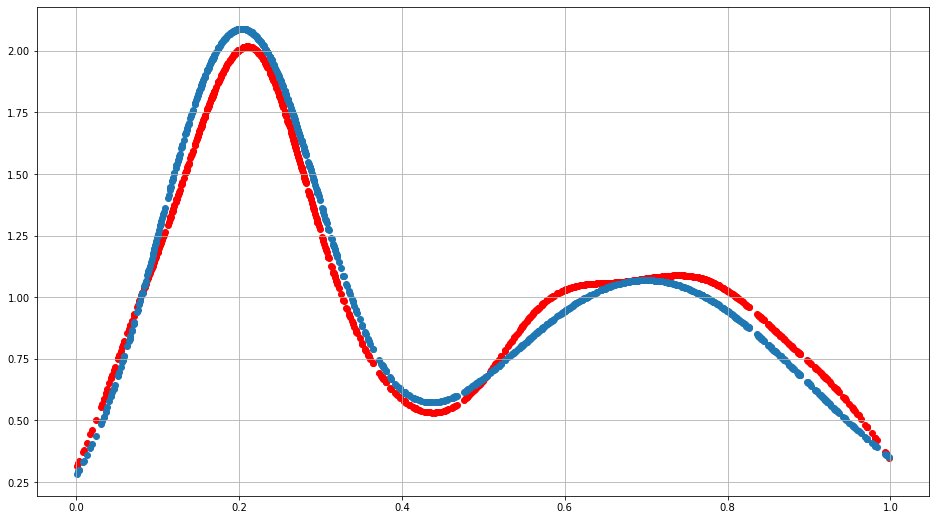

In [14]:
plt.figure(figsize=(16,9))
plt.grid()
plt.scatter(x, fa(x), c="r")
plt.scatter(x, f(x))
plt.plot()

In [34]:
((fa(np.linspace(0,1,10000)) - f(np.linspace(0,1,10000)))**2).mean()

0.005864052710608343